# Yeast

In [1]:
# Import necessary libraries
from encodings import search_function
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary tools from the sklearn library
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Import sklearn library tools used ONLY for validating my results
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

In [27]:
def main():

    # read dataset from csv file
    data_name = "yeast_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20, random_state=2200)
    return train_X, test_X, train_y, test_y, data_X, data_y

## LDA

In [28]:
class myLDA(object):
    '''
    This class is for linear discriminant analysis classification.
    
    The class contains the parameters of LDA, including the number of classes and the prior probability p(i) of 
    each class $i$, where $i=1,2,\ldots,num_classes$. Moreover, the class contains the the mean vectors $\mu_i$ 
    and covariance matrix $\Sigma$ of probability distributions $p(x|i)$ for the class $i$.
    
    It also contains the functions for initializing the class, fitting the LDA classifier model, use 
    the fitted model to calculate the linear discriminant functions $\delta_i(x)$ and decision function $h^*(x)$.
    
    Attributes:
        mu (matrix, num_classes*num_features)    : mean vectors of distributions $p(x|i)$. The $i$-th row represents $\mu_i$.
        Sigma (matrix, num_features*num_features): covariance matrix
        num_classes (positive integer)           : the number of classes
        priorProbs (vector, num_classes)         : the prior probability vector and its $i$-th element is $p(i)$
        
    '''
    def __init__(self):
        '''
        Initialize the class by just assigning zero to all atrributes. 
        '''
        self.mu = 0 
        self.Sigma = 0
        self.num_classes = 0
        self.priorProbs = 0
        
    def fit(self, X, y):
        '''
        estimate the mean vector and covariance matrix of each class in the LDA model
        
        Args: 
            X (matrix, num_train*num_features): features of training samples
            y (matrix, num_train): label of training samples
            
        Returns:
            mu (matrix, num_classes*num_features)    : mean vectors of distributions $p(x|i)$. The $i$-th row represents $\mu_i$.
            Sigma (matrix, num_features*num_features): covariance matrix
        ''' 
        num_samples, num_features = X.shape
        values, counts = np.unique(y, return_counts = True)
        num_classes = len(values)
        ### calculate the prior probability $p(i)$
        self.priorProbs = counts / num_samples
        ### calculate the mean vector of each class $\mu_i$
        self.mu = np.zeros((num_classes, num_features))
        for k in range(num_samples):
            self.mu[int(y[k]),:] += X[k,:]
        self.mu = self.mu / np.expand_dims(counts, 1) 
        ### calculate the covariance matrix $\Sigma$
        Sigma_i = [np.cov(X[y == i].T)*(X[y == i].shape[0]-1) for i in range(num_classes)] 
        self.Sigma = sum(Sigma_i) / (X.shape[0]-num_classes)
        return self.mu, self.Sigma
    
    def linear_discriminant_func(self, X):
        '''
        calculate the linear discriminant functions $\delta_i(X)$
        
        Args: 
            X (matrix, num_samples*num_features): features of samples
            
        Returns:
            value (matrix, num_samples*num_classes): the linear discriminant function values. 
            The $(j,i)$-th entry of value represents $\delta_i(X[j,:])$, which is the linear discriminant function value for the class $i$ of the sample at row $j$.
        '''
        ### calculate the inverse matrix of the covariance matrix $\Sigma$
        U, S, V = np.linalg.svd(self.Sigma)
        Sn = np.linalg.inv(np.diag(S))
        Sigma_inv = np.dot(np.dot(V.T, Sn), U.T)
        ### calculate the linear discriminant function values of X
        value = np.dot(np.dot(X, Sigma_inv), self.mu.T) - \
                0.5 * np.multiply(np.dot(self.mu, Sigma_inv).T, self.mu.T).sum(axis = 0).reshape(1, -1) + \
                np.log(np.expand_dims(self.priorProbs, axis = 0))
        return value
    
    def predict(self, X):
        '''
        calculate the linear discriminant functions
        
        Args: 
            X (matrix, num_samples*num_features): features of samples
            
        Returns:
            pred_label (vector, num_samples): the predicted labels of samples. The $j$-th entry represents the predicted label of the sample at row $j$.
        '''
        pred_value = self.linear_discriminant_func(X)
        pred_label = np.argmax(pred_value, axis = 1)
        return pred_label

In [29]:
### initiate the LDA model
model = myLDA()
### fit the model with training data and get the estimation of mu and Sigma
mu, Sigma = model.fit(main()[0], main()[2])
### predict the label of test data
y_pred = model.predict(main()[1])
### calculate the accuracy of the fitted LDA model on test data
accuracy = np.sum(y_pred == main()[3])/len(main()[3])
print("Accuracy of LDA on the test dataset is {}.".format(accuracy))

Accuracy of LDA on the test dataset is 0.5488215488215489.


I runned my model and obtained a 0.56% accuracy. Not bad for having selected random hyper-paramenters, but maybe with a better understanding of my dataset, some data-cleaning, and sklearn tool-kit can make the difference.  

In [41]:
# I am loading the full dataset and renaming the columns to keep better track of each attribute
data_dir = "..\..\..\data\data_classification"
data_path = os.path.join(data_dir, "yeast_classification.csv")
df = pd.read_csv(data_path, header=0)
col_names = ['col_1','col_2','col_3','col_4','col_5','col_6','col_7','col_8','name']
df.columns = col_names

df.head(3)
df =df.drop(columns=['col_2'])

In [42]:
# Check for high correlation among features
df.corr()

,col_1,col_3,col_4,col_5,col_6,col_7,col_8
col_1,1.000000,-0.163951,0.158175,0.064922,0.005597,0.075043,-0.124540
col_3,-0.163951,1.000000,0.059668,-0.008083,0.009378,-0.185805,-0.022043
col_4,0.158175,0.059668,1.000000,-0.005931,-0.009040,-0.103591,-0.054797
col_5,0.064922,-0.008083,-0.005931,1.000000,-0.009674,0.043627,0.002829
col_6,0.005597,0.009378,-0.009040,-0.009674,1.000000,0.020900,-0.035659
col_7,0.075043,-0.185805,-0.103591,0.043627,0.020900,1.000000,0.089690
col_8,-0.124540,-0.022043,-0.054797,0.002829,-0.035659,0.089690,1.000000


In [43]:
df.describe()

,col_1,col_3,col_4,col_5,col_6,col_7,col_8
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


In [44]:
print(df.name.value_counts())

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: name, dtype: int64


<AxesSubplot:>

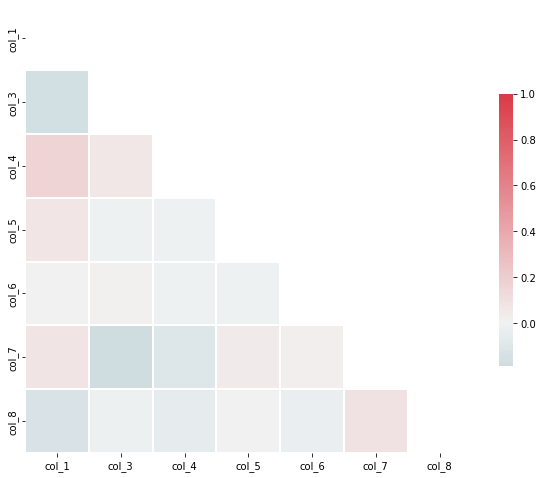

In [45]:
corr                             = df.corr()
mask                             = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax                            = plt.subplots(figsize=(10,50))
cmap                             = sns.diverging_palette(220, 10, as_cmap=True)

# Matix
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .1})

I found a correlation between the different measurements of Hold, Pressure and Finger-Area with their averages. I also found a correlation with the different measurements of Hold.

In [58]:
### initiate the LDA model
data_X = df.iloc[:,:-1]
data_y = df.iloc[:,-1]
scaler_X = StandardScaler()
data_X = scaler_X.fit_transform(data_X)
data_y = pd.Categorical(data_y).codes.reshape(-1)
# Randomly assingning a train and test set
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20, random_state=13)

model = myLDA()
### fit the model with training data and get the estimation of mu and Sigma
mu, Sigma = model.fit(train_X, train_y)
### predict the label of test data
y_pred = model.predict(test_X)
### calculate the accuracy of the fitted LDA model on test data
accuracy = np.sum(y_pred == test_y)/len(test_y)
print("Accuracy of LDA on the test dataset is {}.".format(accuracy))

Accuracy of LDA on the test dataset is 0.5993265993265994.


In [59]:
algo_f = RandomForestClassifier()
algo_lda = LinearDiscriminantAnalysis()
algo_dt = DecisionTreeClassifier()
model_forrest = algo_f.fit(main()[0], main()[2])
model_LDA = algo_lda.fit(main()[0], main()[2])
model_DT = algo_dt.fit(main()[0], main()[2])

In [61]:
print(" Accuracy: %.3f for the DT model" % (model_DT.score(main()[1], main()[3])*100.0))
print(" Accuracy: %.3f for the forrest model" % (model_forrest.score(main()[1], main()[3])*100.0))
print(" Accuracy: %.3f for the LDA model" % (model_LDA.score(main()[1], main()[3])*100.0))

 Accuracy: 48.485 for the DT model
 Accuracy: 62.626 for the forrest model
 Accuracy: 54.882 for the LDA model


In [62]:
# I again use the processed data from the logistic regression but this time I specify SVC

SVM_best_scores = {}
tree_param = {'criterion':['gini','entropy'],'max_depth':np.arange(3, 15)}
search_svm = GridSearchCV(estimator = algo_dt ,param_grid= tree_param,
                    cv = 5, return_train_score = True,
                    n_jobs = -1)

search_svm.fit(main()[0], main()[2])
SVM_best_scores = {'model':search_svm, 'best_params':search_svm.best_params_,
                        'best_score':search_svm.best_score_}

In [63]:
SVM_best_scores['best_params']

{'criterion': 'gini', 'max_depth': 5}

In [64]:
clf = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)

In [65]:
# utilisation d'une grille complete avec toutes les parametres jugés nécessaires

param_grid = {
    "n_estimators": [10,20,71],
    "bootstrap": [False],
    "criterion": ["gini", "entropy"],
    "min_samples_split" : [3,7, 10],
    "max_depth" :range(10)[1:],
    "max_features": ['auto', 'sqrt']
}

# Effectuer grid search
grid_search = GridSearchCV(algo_f, param_grid=param_grid, cv=5)
grid_search.fit(main()[0], main()[2])
forrest_best_scores = {'model':grid_search, 'best_params':grid_search.best_params_,
                        'best_score':grid_search.best_score_}
forrest_best_scores

{'model': GridSearchCV(cv=5, estimator=RandomForestClassifier(),
              param_grid={'bootstrap': [False], 'criterion': ['gini', 'entropy'],
                          'max_depth': range(1, 10),
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_split': [3, 7, 10],
                          'n_estimators': [10, 20, 71]}),
 'best_params': {'bootstrap': False,
  'criterion': 'entropy',
  'max_depth': 9,
  'max_features': 'auto',
  'min_samples_split': 10,
  'n_estimators': 71},
 'best_score': 0.626809204694536}

Found some improved paramenters

# Classification tree

In [ ]:
# load datasets function
def load_data(data_file_name):
    data_dir = "..\..\..\data\data_classification"
    data_path = os.path.join(data_dir, data_file_name)
    df = pd.read_csv(data_path, header=1)
    data_X = df.iloc[:,:-1]
    data_y = df.iloc[:,-1]
    scaler_X = StandardScaler()
    data_X = scaler_X.fit_transform(data_X)
    data_y = pd.Categorical(data_y).codes.reshape(-1)
    return data_X, data_y

In [ ]:

def main():

    # read dataset from csv file
    data_name = "yeast_classification"
    data_X, data_y = load_data("{}.csv".format(data_name))

    return data_X, data_y

## Criterion -- Gini Index

In [ ]:
def calculate_weighted_counts(y, sample_weight, classes_):
    '''
    the function used to calculate the summation of weights of samples from each class. Generally speaking,
    the weights are all set as one. But for Adaboost, each sample has different values.
    '''
    class_counts = np.zeros(shape=classes_.shape[0], dtype=np.float64)
    for i, label in enumerate(classes_):
        idx = y == label
        if idx.sum() > 0:
            class_counts[i] = sample_weight[idx].sum()
        else:
            class_counts[i] = 0
    return class_counts

def gini(y, sample_weight):
    classes_ = np.unique(y)
    class_counts = calculate_weighted_counts(y, sample_weight, classes_)
    if class_counts.sum() > 0:
        pk = class_counts / class_counts.sum()
        pk = pk[pk > 0]
        return 1 - np.sum(pk**2)
    else:
        return 0

def gini_index(X, y, feat, point, sample_weight):
    '''
    calculate the difference of gini index before and after splitting
    '''
    S = gini(y, sample_weight)
    new_S = 0
    n = sample_weight.sum()
    assert n > 0
    idx1 = X[:, feat] < point
    nv = sample_weight[idx1].sum()
    if nv > 0:
        new_S += nv / n * gini(y[idx1], sample_weight[idx1])
    idx2 = X[:, feat] >= point
    nv = sample_weight[idx2].sum()
    if nv > 0:
        new_S += nv / n * gini(y[idx2], sample_weight[idx2])
    return S - new_S

# 3. Decision Trees for Classification

Different from the classification tree implemented in the last tutorial:
1. Each internal node has two child nodes regardless of values of the splitting feature are continuous or discrete.
2. Add the parameter `max_depth` for providing another condition to stop splitting procedures.
3. Add the parameter `max_features` to use the subset of features to build decision tree.

Options 2&3 are designed for constructing trees in the random forest implemented in Section 5. 

If you'd like to build the classification tree, you can ignore options 2&3 by setting `max_depth = None` and `max_features = None`. Then we can combine it with the pre-pruning or post-pruning technique implemented in Section 4 to prevent overfitting.

In [ ]:
class DecisionTreeClassifier(object):
    '''
    This class is for classification tree

    Attributes:
        - criterion: a function used as the criterion of classification tree
        - tree: a nested dictionary representing the decision tree structure.
        - max_depth: the parameter to control the depth of tree. If the depth is larger than max_depth, we will stop splitting.
        - max_feature: the number of selected features to build decision tree
    '''
    def __init__(self,
                 criterion=gini_index,
                 max_depth=None,
                 max_features=None,
                 random_seed=None):
        self.f_criterion = criterion
        self.max_depth = max_depth
        if self.max_depth is None:
            self.max_depth = 2**10
        self.max_features = max_features
        self.random_seed = random_seed

    def fit(self, X, y, sample_weight=None):
        np.random.seed(self.random_seed)
        num_samples, num_features = X.shape
        if self.max_features is None:
            self.max_features = num_features
        elif self.max_features == "sqrt":
            self.max_features = np.int(np.round(np.sqrt(num_features)))
        self.classes_ = np.unique(y)
        if sample_weight is None:
            sample_weight = np.ones(num_samples, dtype=np.float64)
        # build the decision tree
        self.tree = self.create_tree(X, y, sample_weight, depth=0)

    def create_tree(self, X, y, sample_weight, depth):
        Tree = {}
        Tree["depth"] = depth
        class_counts = calculate_weighted_counts(y, sample_weight, self.classes_)
        # create a leaf node if all samples belong to the same class
        if (class_counts != 0).sum() == 1:
            Tree["is_leaf"] = True
            Tree["pred"] = self.classes_[class_counts != 0]
        # using the majority vote to get the prediction at each node
        majority_class = self.classes_[np.argmax(class_counts)]
        Tree["pred"] = majority_class
        # create a leaf node if feature set is empty
        feat, point = self.choose_best_split(X, y, sample_weight)
        if feat is None or depth == self.max_depth:
            Tree["is_leaf"] = True
            return Tree
        # otherwise, create an internal node
        Tree["is_leaf"] = False
        Tree["split_feat"] = feat
        Tree["split_point"] = point
        # build the left subtree
        idx = X[:, feat] < point
        Tree["left"] = self.create_tree(X[idx], y[idx], sample_weight[idx],
                                        depth + 1)
        # build the right subtree
        idx = X[:, feat] >= point
        Tree["right"] = self.create_tree(X[idx], y[idx], sample_weight[idx],
                                         depth + 1)
        return Tree

    def choose_best_split(self, X, y, sample_weight):
        # initialization
        best_feat, best_point = None, None
        best_score = 0.0
        # search for each candidate feature
        num_features = X.shape[1]
        if self.max_features < num_features:
            candidate_feat = np.random.permutation(
                num_features)[:self.max_features]
        else:
            candidate_feat = np.arange(num_features)
        for feat in candidate_feat:
            # if all values of this feature are equal, do not split this feature
            X_feat_value = np.unique(X[:, feat])
            if len(X_feat_value) == 1:
                continue
            # search for each possible split point
            for i in range(len(X_feat_value) - 1):
                # divide the dataset into two parts according to the split
                point = (X_feat_value[i] + X_feat_value[i + 1]) / 2.0
                # calculate score to evaluate the quality of a split
                score = self.f_criterion(X, y, feat, point, sample_weight)
                if score > best_score:
                    best_feat = feat
                    best_point = point
                    best_score = score
        return best_feat, best_point

    def predict(self, X):
        '''
        function used to fit the decision tree classifier

        Args:
            X - features of test samples, a pandas dataframe with shape (n, d)

        Returns:
            y - predictions of test samples, a pandas series with shape (n,)
        '''
        n = X.shape[0]
        y = []
        for i in range(n):
            y.append(DecisionTreeClassifier.predict_each(X[i], self.tree))
        y = np.array(y, dtype=np.int32)
        return y

    @staticmethod
    def predict_each(x, tree):
        '''
        for each sample, get the prediction of decision tree classifier in a recursive manner.

        Args:
            x - features of a sample, a pandas Series with shape (d,)
            tree - a nested dictionary representing the decision tree structure.

        Returns:
            the prediction of the sample `x`
        '''
        if tree["is_leaf"] is True:
            # if the `tree` is a leaf node, get the prediction at the leaf node
            return tree["pred"]
        else:
            # the 'tree' is a nested dictionary
            # get the value of the feature used to split
            feat = tree["split_feat"]
            point = tree["split_point"]
            # get the value of the feature for the sample `x`
            value = x[feat]
            if value < point:
                return DecisionTreeClassifier.predict_each(x, tree["left"])
            else:
                return DecisionTreeClassifier.predict_each(x, tree["right"])

In [ ]:
def t_t():
    # Randomly assingning a train and test set
    train_X, test_X, train_y, test_y = train_test_split(main()[0], main()[1], test_size=0.33, random_state=100)
    return train_X, test_X, train_y, test_y

In [ ]:
X_train, X_test, y_train, y_test = t_t()
model = DecisionTreeClassifier(criterion=gini_index,
                                   max_depth=None,
                                   max_features=None,
                                   random_seed=None)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("The accuracy of training data is:", acc_train)
print("The accuracy of test data is:", acc_test)

The accuracy of training data is: 1.0
The accuracy of test data is: 0.4959183673469388


You maybe find that the accuracy of training data is almost one but the accuracy of test data is low. The reason is that the decision tree overfits to the training data. To prevent overfitting, we introduce the post-pruning technique in the next section.

# 4. Classification Tree with the Pruning Technique

In [ ]:
def pruning(tree, classes_, X_valid, y_valid):
    '''
    the function used to post-prune the decision tee

    Args:
        tree - a nested dictionary representing the decision tree structure.
        classes_ - names of all classes 
        X_valid - the features of the validation samples
        y_valid - the labels of the validation samples
    Returns:
        the tree structure after pruning
   '''
    if X_valid.shape[0] == 0:
        new_tree = {}
        new_tree["is_leaf"] = True
        new_tree["pred"] = tree["pred"]
        return new_tree
    if tree["is_leaf"] is True:
        return tree
    feat = tree["split_feat"]
    point = tree["split_point"]
    idx1 = X_valid[:, feat] < point
    tree["left"] = pruning(tree["left"], classes_, X_valid[idx1],
                           y_valid[idx1])
    idx2 = X_valid[:, feat] >= point
    tree["right"] = pruning(tree["right"], classes_, X_valid[idx2],
                            y_valid[idx2])
    if tree["left"]["is_leaf"] is True and tree["right"]["is_leaf"] is True:
        FLAG = True
    else:
        FLAG = False
    if FLAG:
        # check validation accuracy gap
        valid_y_true = []
        valid_y_pred = []
        # make prediction and calculate validation accuracy of the tree before merging
        child_majority_class = tree["left"]["pred"]
        idx1 = X_valid[:, feat] < point
        if idx1.sum() > 0:
            valid_y_true.append(y_valid[idx1])
            valid_y_pred.append([child_majority_class] * idx1.sum())
        child_majority_class = tree["right"]["pred"]
        idx2 = X_valid[:, feat] >= point
        if idx2.sum() > 0:
            valid_y_true.append(y_valid[idx2])
            valid_y_pred.append([child_majority_class] * idx2.sum())
        valid_y_true = np.concatenate(valid_y_true)
        valid_y_pred = np.concatenate(valid_y_pred)
        valid_acc_before = np.mean(valid_y_true == valid_y_pred)
        # make prediction and calculate validation accuracy of the tree after merging
        majority_class = tree["pred"]
        valid_y_pred = np.array([majority_class] * X_valid.shape[0])
        valid_acc_after = np.mean(valid_y_true == valid_y_pred)
        # if the validation accuracy after merging is larger, we will prune
        if valid_acc_after > valid_acc_before:
            new_tree = {}
            new_tree["is_leaf"] = True
            new_tree["pred"] = tree["pred"]
            return new_tree
        else:
            return tree
    else:
        return tree

In [ ]:
X_train, X_test, y_train, y_test = t_t()
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=0.3,
                                                      stratify=y_train,
                                                      random_state=3147)
model = DecisionTreeClassifier(criterion=gini_index,
                                   max_depth=None,
                                   max_features=None,
                                   random_seed=None)
model.fit(X_train, y_train)
# without pruning
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_valid = (y_valid == y_valid_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the classification tree Without pruning is:", acc_train)
print("Validation accuracy of the classification tree Without pruning is:", acc_valid)
print("Testing accuracy of the classification tree Without pruning is:", acc_test, '\n')
# with pruning
model.tree = pruning(model.tree, model.classes_, X_valid, y_valid)
y_train_hat = model.predict(X_train)
y_valid_hat = model.predict(X_valid)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_valid = (y_valid == y_valid_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the classification tree With pruning is:", acc_train)
print("Validation accuracy of the classification tree With pruning is:", acc_valid)
print("Testing accuracy of the classification tree With pruning is:", acc_test)

Training accuracy of the classification tree Without pruning is: 1.0
Validation accuracy of the classification tree Without pruning is: 0.4865771812080537
Testing accuracy of the classification tree Without pruning is: 0.44693877551020406 

Training accuracy of the classification tree With pruning is: 0.9309352517985612
Validation accuracy of the classification tree With pruning is: 0.5570469798657718
Testing accuracy of the classification tree With pruning is: 0.46938775510204084


# 5. Random Forest for Classification

In this section, we implement the random forest where each tree is built with the class DecisionTreeClassifier(). In our model, the values of parameters are listed below. 
1. The number of trees $T$ is set as ``num_estimators = 20``
2. the number of subsampled features for each tree is $k =\sqrt{d}$, which corresponds to ``max_features = "sqrt"`` in the code.
3. The maximum depth of each tree is ``max_depth = 6``.

We will not use the pruning technique for each tree in the random forest.

In [ ]:
class RandomForestClassifier(object):
    '''
    This class is for random forest classification

    Attributes:
        - criterion: a function used as the criterion of classification tree
        - num_estimators: the number of trees in the random forest 
        - tree: a nested dictionary representing the decision tree structure
        - max_depth: the parameter to control the depth of tree. If the depth is larger than max_depth, we will stop splitting.
        - max_feature: the number of selected features to build decision tree
    '''
    def __init__(self,
                 num_estimators,
                 random_state,
                 criterion=gini_index,
                 max_depth=None,
                 max_features="sqrt"):
        self.num_estimators = num_estimators
        self.random_state = random_state
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = max_features

    def fit(self, X, y):
        '''
        function used to fit all trees in the random forest
        
        Args:
            X - the features of the training samples
            y - the labels of the training samples
        Returns:
            self.model_list - the model list containing `num_estimators` tree models
        '''
        n, d = X.shape
        RandomState = np.random.RandomState(self.random_state)
        self.model_list = []
        for t in range(self.num_estimators):
            random_seed = RandomState.randint(0, np.iinfo(np.int32).max)
            ### draw a bootstrapped dataset from X
            sample_index = RandomState.choice(np.arange(n), size=n, replace=True)
            X_sampled = X[sample_index, :]
            y_sampled = y[sample_index]
            ### initialize the tree model by using DecisionTreeClassifier()
            model = DecisionTreeClassifier(criterion=self.criterion,
                                           max_depth=self.max_depth,
                                           max_features=self.max_features,
                                           random_seed=random_seed)
            ### fit the tree model to the bootstrapped dataset by using DecisionTreeClassifier.fit()
            model.fit(X_sampled, y_sampled)
            self.model_list.append(model)
        return self.model_list

    def predict(self, X):
        '''
        function used to predict the labels of X
        
        Args:
            X - the features of the test samples
        Returns:
            y_pred_label - the predicted labels of test samples
        '''
        n = X.shape[0]
        y_pred = np.zeros([self.num_estimators, n], dtype=np.int32)
        y_pred_label = np.zeros(n, dtype=np.int32)
        ### use T tree classifiers to make predictions by using DecisionTreeClassifier.predict()
        for i in range(self.num_estimators):
            model_i = self.model_list[i]
            y_pred[i, :] = model_i.predict(X)
        ### take the majority vote 
        for i in range(n):
            classes, count = np.unique(y_pred[:, i], return_counts=True)
            y_pred_label[i] = classes[np.argmax(count)]
        return y_pred_label

In [ ]:
X_train, X_test, y_train, y_test = t_t()
model = RandomForestClassifier(num_estimators=20,
                                   random_state=101,
                                   criterion=gini_index,
                                   max_depth=6)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
acc_train = (y_train == y_train_hat).mean()
acc_test = (y_test == y_test_hat).mean()
print("Training accuracy of the random forest is:", acc_train)
print("Testing accuracy of the random forest is:", acc_test)

Training accuracy of the random forest is: 0.6626384692849949
Testing accuracy of the random forest is: 0.6163265306122448
